In [8]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

from imports import *
import numpy as np
import h5py
import json
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal
from scipy import stats
from target import build_tgt_matrix
import pandas as pd
from loading import load_session_data
from session.sessions import selected_009266, selected_009265

%matplotlib inline

In [9]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [10]:
sessions = [s for s in selected_009265.keys()]
sessions.sort()
sessions

['009265_hippoSIT_2023-02-24_09-53-26',
 '009265_hippoSIT_2023-02-24_17-22-46',
 '009265_hippoSIT_2023-02-27_10-18-32',
 '009265_hippoSIT_2023-02-27_15-33-46',
 '009265_hippoSIT_2023-02-28_09-16-50',
 '009265_hippoSIT_2023-02-28_13-16-10',
 '009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34',
 '009265_hippoSIT_2023-04-13_09-54-39',
 '009265_hippoSIT_2023-04-20_11-39-02']

In [13]:
session = sessions[5]

session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
areas = session_data['areas']
aeps = session_data['aeps']
aeps_events = session_data['aeps_events']
AEP_metrics_lims = session_data['AEP_metrics_lims']
AEP_metrics_raw = session_data['AEP_metrics_raw']
AEP_metrics_norm = session_data['AEP_metrics_norm']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
animal = session_data['animal']
aeps_file = session_data['aeps_file']
h5_file = session_data['h5_file']
report_path = session_data['report_path']
session

'009265_hippoSIT_2023-02-28_13-16-10'

## Background / Target

In [14]:
#coma_start, coma_end = 2200, 4000
aeps_A1_bgr_mean  = aeps['A1'][aeps_events[:, 1] == 1].mean(axis=0)
aeps_A1_tgt_mean  = aeps['A1'][aeps_events[:, 1] == 2].mean(axis=0)
aeps_PPC_bgr_mean = aeps['PPC'][aeps_events[:, 1] == 1].mean(axis=0)
aeps_PPC_tgt_mean = aeps['PPC'][aeps_events[:, 1] == 2].mean(axis=0)

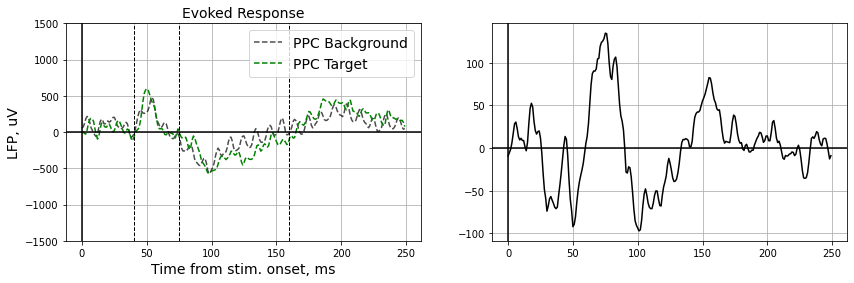

In [16]:
y_lim = 1500

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
#axes[0].plot(aeps_A1_bgr_mean, color='black', label='A1 Background', alpha=0.7)
#axes[0].plot(aeps_A1_tgt_mean, color='green', label='A1 Target')
axes[0].plot(8*aeps_PPC_bgr_mean, color='black', ls='--', label='PPC Background', alpha=0.7)
axes[0].plot(8*aeps_PPC_tgt_mean, color='green', ls='--',  label='PPC Target')
axes[0].axhline(0, color='black')
axes[0].axvline(0, color='black')
axes[0].legend(loc='upper right', prop={'size': 14})
axes[0].set_xlabel('Time from stim. onset, ms', fontsize=14)
axes[0].set_ylabel('LFP, uV', fontsize=14)
axes[0].set_title('Evoked Response', fontsize=14)
axes[0].set_ylim(-y_lim, y_lim)
axes[0].grid()
#for i, (key, value) in enumerate(AEP_metrics_lims.items()):
#   axes[0].axvline(value[0], color='black', ls='--', lw=1)
#   axes[0].axvline(value[1], color='black', ls='--', lw=1)
#axes[0].axvline(15, color='black', ls='--', lw=1)
axes[0].axvline(40, color='black', ls='--', lw=1)
axes[0].axvline(75, color='black', ls='--', lw=1)
#axes[0].axvline(115, color='black', ls='--', lw=1)
axes[0].axvline(160, color='black', ls='--', lw=1)


# MMR strength
axes[1].plot(aeps_A1_bgr_mean - aeps_A1_tgt_mean, color='black')
axes[1].axhline(0, color='black')
axes[1].axvline(0, color='black')
axes[0].set_ylim(-y_lim, y_lim)
#axes[1].axvspan(90, 130, alpha=0.2, color='black')
axes[1].grid()

fig.savefig(os.path.join(report_path, 'AEP_tgt_bgr.pdf'))

## Component correlations between regions

In [23]:
selected_sessions = [
    '009266_hippoSIT_2023-04-17_17-04-17',
    '009266_hippoSIT_2023-04-18_10-10-37',
    '009266_hippoSIT_2023-04-18_17-03-10',
    '009266_hippoSIT_2023-04-19_10-33-51',
    '009266_hippoSIT_2023-04-24_16-56-55',
    '009266_hippoSIT_2023-05-02_12-22-14',
]

selected_sessions = sessions[:]
selected_sessions

['009265_hippoSIT_2023-02-24_09-53-26',
 '009265_hippoSIT_2023-02-24_17-22-46',
 '009265_hippoSIT_2023-02-27_10-18-32',
 '009265_hippoSIT_2023-02-27_15-33-46',
 '009265_hippoSIT_2023-02-28_09-16-50',
 '009265_hippoSIT_2023-02-28_13-16-10',
 '009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34',
 '009265_hippoSIT_2023-04-13_09-54-39',
 '009265_hippoSIT_2023-04-20_11-39-02']

### Corr coeffs

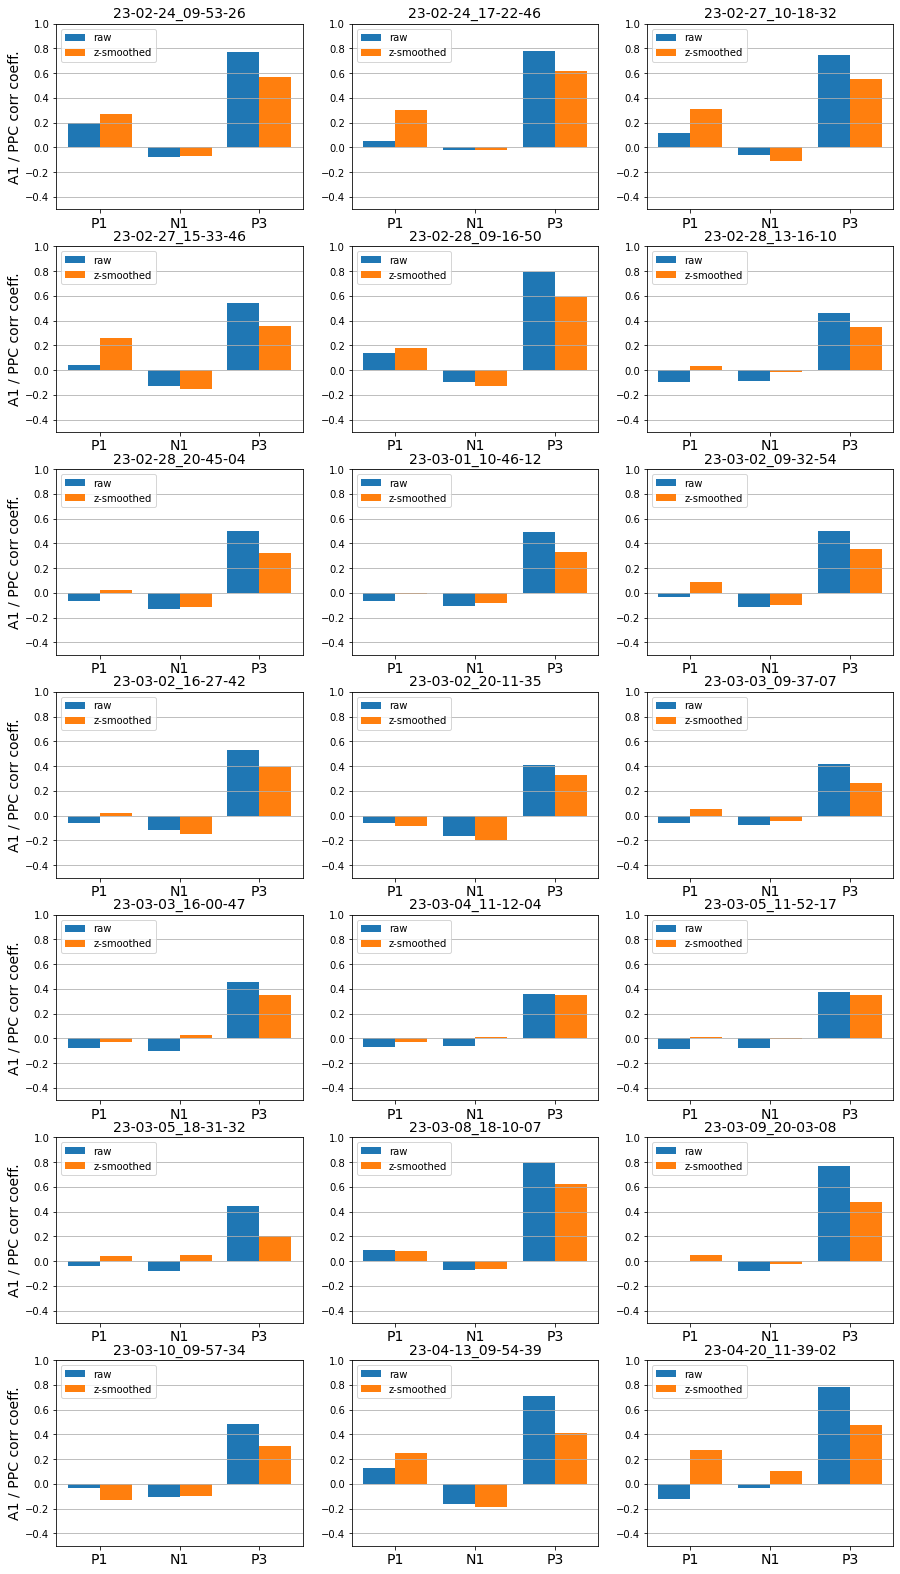

In [25]:
rows = int(np.ceil(len(selected_sessions)/3))
fig = plt.figure(figsize=(15, rows*4))

for i, session in enumerate(selected_sessions):
    animal      = session.split('_')[0]
    sessionpath = os.path.join(source, animal, session)
    aeps_file   = os.path.join(sessionpath, 'AEPs.h5')

    # load metrics
    with h5py.File(aeps_file, 'r') as f:
        grp = f['A1']
        AEP_metrics_raw_A1  = {}
        AEP_metrics_norm_A1 = {}
        for metric_name in grp['raw']:
            AEP_metrics_raw_A1[metric_name]  = np.array(grp['raw'][metric_name])
            AEP_metrics_norm_A1[metric_name] = np.array(grp['norm'][metric_name])

        grp = f['PPC']
        AEP_metrics_raw_PPC  = {}
        AEP_metrics_norm_PPC = {}
        for metric_name in grp['raw']:
            AEP_metrics_raw_PPC[metric_name]  = np.array(grp['raw'][metric_name])
            AEP_metrics_norm_PPC[metric_name] = np.array(grp['norm'][metric_name])
            
    metric_corrs_raw  = []
    metric_corrs_norm = []
    for metric in ['P1', 'N1', 'P3']:
        metric_corrs_raw.append(stats.pearsonr(AEP_metrics_raw_A1[metric], AEP_metrics_raw_PPC[metric])[0])
        metric_corrs_norm.append(stats.pearsonr(AEP_metrics_norm_A1[metric], AEP_metrics_norm_PPC[metric])[0])
    
    ax = fig.add_subplot(rows, 3, i+1)
    ax.bar(np.array([1, 2, 3]) - 0.2, metric_corrs_raw, width=0.4, label='raw')
    ax.bar(np.array([1, 2, 3]) + 0.2, metric_corrs_norm, width=0.4, label='z-smoothed')
    ax.set_xticks([1, 2, 3])  # set correct ticks and labels
    ax.set_xticklabels(['P1', 'N1', 'P3'], fontsize=14)
    ax.set_ylim(-0.5, 1)
    if i % 3 == 0:
        ax.set_ylabel('A1 / PPC corr coeff.', fontsize=14)
    ax.legend(loc='upper left')
    ax.grid(axis='y')
    ax.set_title('%s' % session[-17:], fontsize=14)

### Cross-correlograms

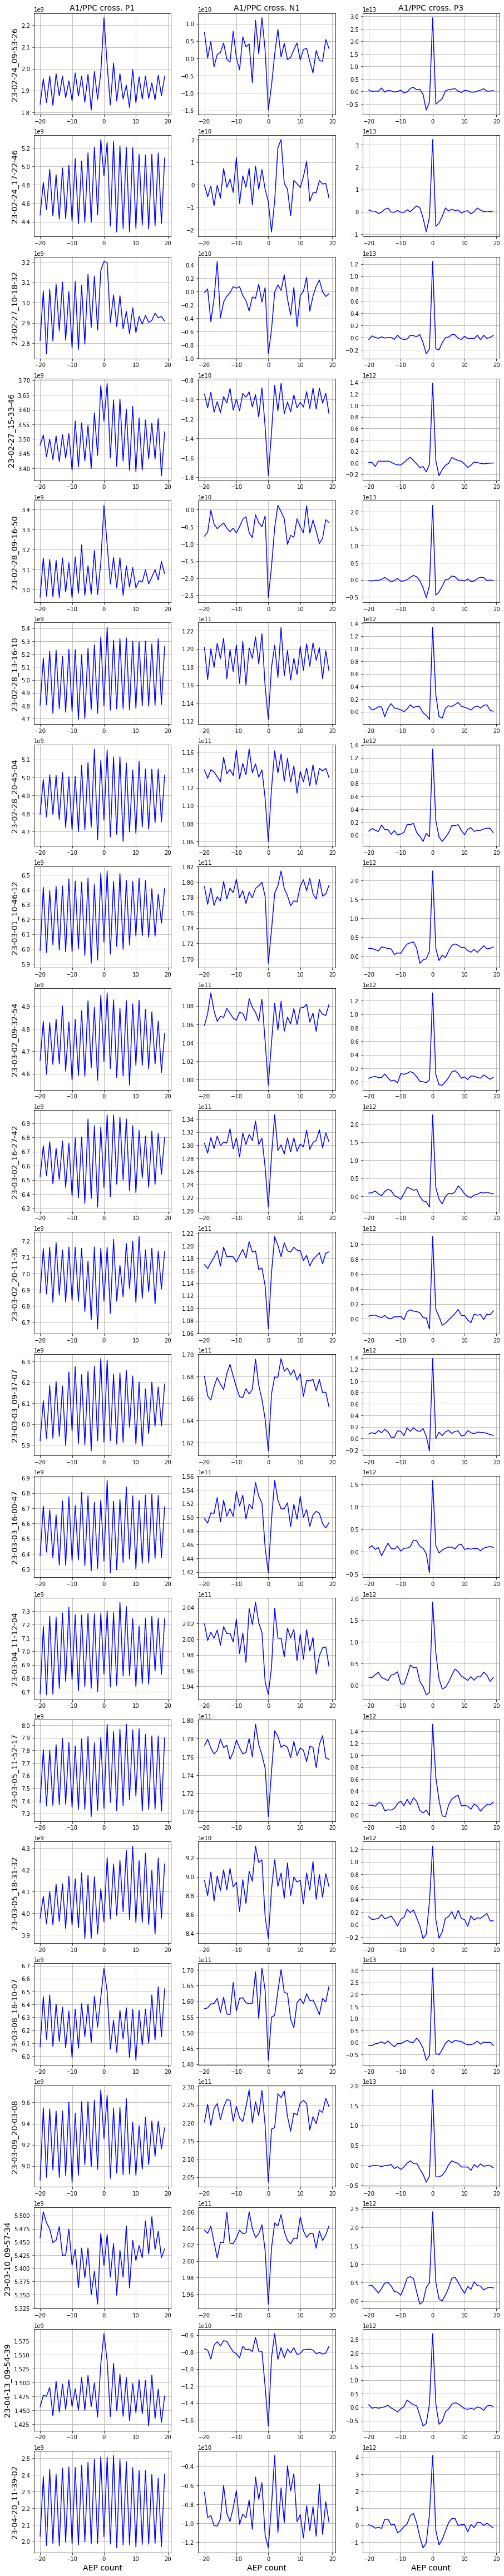

In [28]:
# CCRs
rows = len(selected_sessions)
fig, axes = plt.subplots(rows, 3, figsize=(15, rows*4))

for i, session in enumerate(selected_sessions):
    animal      = session.split('_')[0]
    sessionpath = os.path.join(source, animal, session)
    aeps_file   = os.path.join(sessionpath, 'AEPs.h5')

    # load metrics
    with h5py.File(aeps_file, 'r') as f:
        grp = f['A1']
        AEP_metrics_raw_A1  = {}
        AEP_metrics_norm_A1 = {}
        for metric_name in grp['raw']:
            AEP_metrics_raw_A1[metric_name]  = np.array(grp['raw'][metric_name])
            AEP_metrics_norm_A1[metric_name] = np.array(grp['norm'][metric_name])

        grp = f['PPC']
        AEP_metrics_raw_PPC  = {}
        AEP_metrics_norm_PPC = {}
        for metric_name in grp['raw']:
            AEP_metrics_raw_PPC[metric_name]  = np.array(grp['raw'][metric_name])
            AEP_metrics_norm_PPC[metric_name] = np.array(grp['norm'][metric_name])
            
    for j, metric in enumerate(['P1', 'N1', 'P3']):
        lag_aeps = 20
        
        # CCR raw
        corr = signal.correlate(AEP_metrics_raw_A1[metric], AEP_metrics_raw_PPC[metric])
        lags = signal.correlation_lags(len(AEP_metrics_raw_PPC[metric]), len(AEP_metrics_raw_A1[metric]))
        idx_l, idx_r = int(len(lags)/2) - lag_aeps, int(len(lags)/2) + lag_aeps
        y_min = 0.8*corr[idx_l:idx_r].min()
        y_max = 1.2*corr[idx_l:idx_r].max()
        axes[i, j].plot(lags[idx_l:idx_r], corr[idx_l:idx_r], color='blue')
        
        # CCR norm
        corr = signal.correlate(AEP_metrics_norm_A1[metric], AEP_metrics_norm_PPC[metric])
        lags = signal.correlation_lags(len(AEP_metrics_norm_PPC[metric]), len(AEP_metrics_norm_A1[metric]))
        idx_l, idx_r = int(len(lags)/2) - lag_aeps, int(len(lags)/2) + lag_aeps
        #axes[i, j].plot(lags[idx_l:idx_r], corr[idx_l:idx_r], color='blue')
        
        axes[i, j].grid()
        if i == 0:
            axes[i, j].set_title("A1/PPC cross. %s" % metric, fontsize=14)
        if j == 0:
            axes[i, j].set_ylabel('%s' % session[-17:], fontsize=14)
        if i == rows - 1:
            axes[i, j].set_xlabel('AEP count', fontsize=14)

### Correlation in time

In [164]:
session     = selected_sessions[5]
animal      = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
aeps_file   = os.path.join(sessionpath, 'AEPs.h5')
h5_file     = os.path.join(sessionpath, session + '.h5')

with h5py.File(h5_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result
    cfg = json.loads(f['processed'].attrs['parameters'])
    
with h5py.File(aeps_file, 'r') as f:
    aeps_A1 = np.array(f['A1']['aeps'])
    aeps_PPC = np.array(f['PPC']['aeps'])
    aeps_events = np.array(f['aeps_events'])
    
# load metrics
with h5py.File(aeps_file, 'r') as f:
    grp = f['A1']
    AEP_metrics_raw_A1  = {}
    AEP_metrics_norm_A1 = {}
    for metric_name in grp['raw']:
        AEP_metrics_raw_A1[metric_name]  = np.array(grp['raw'][metric_name])
        AEP_metrics_norm_A1[metric_name] = np.array(grp['norm'][metric_name])

    grp = f['PPC']
    AEP_metrics_raw_PPC  = {}
    AEP_metrics_norm_PPC = {}
    for metric_name in grp['raw']:
        AEP_metrics_raw_PPC[metric_name]  = np.array(grp['raw'][metric_name])
        AEP_metrics_norm_PPC[metric_name] = np.array(grp['norm'][metric_name])

In [165]:
tgt_matrix = build_tgt_matrix(tl, trials, aeps_events)

aeps_A1.shape, aeps_PPC.shape, tgt_matrix.shape

((5976, 200), (5976, 200), (78, 5))

In [166]:
window_l = 10  # in AEP events, 10 sec is ~40 events

def get_time_corrs(metrics1, metrics2):
    time_corrs = {}
    for metric in ['P1', 'N1', 'P3']:
        inst_corrs = np.zeros(len(metrics1[metric]) - window_l)
        metric1 = metrics1[metric]
        metric2 = metrics2[metric]
        for i in range(len(inst_corrs)):
            inst_corrs[i] = stats.pearsonr(metric1[i:i + window_l], metric2[i:i + window_l])[0]

        time_corrs[metric] = np.array(inst_corrs)
    return time_corrs

time_corrs_raw  = get_time_corrs(AEP_metrics_raw_A1, AEP_metrics_raw_PPC)
time_corrs_norm = get_time_corrs(AEP_metrics_norm_A1, AEP_metrics_norm_PPC)

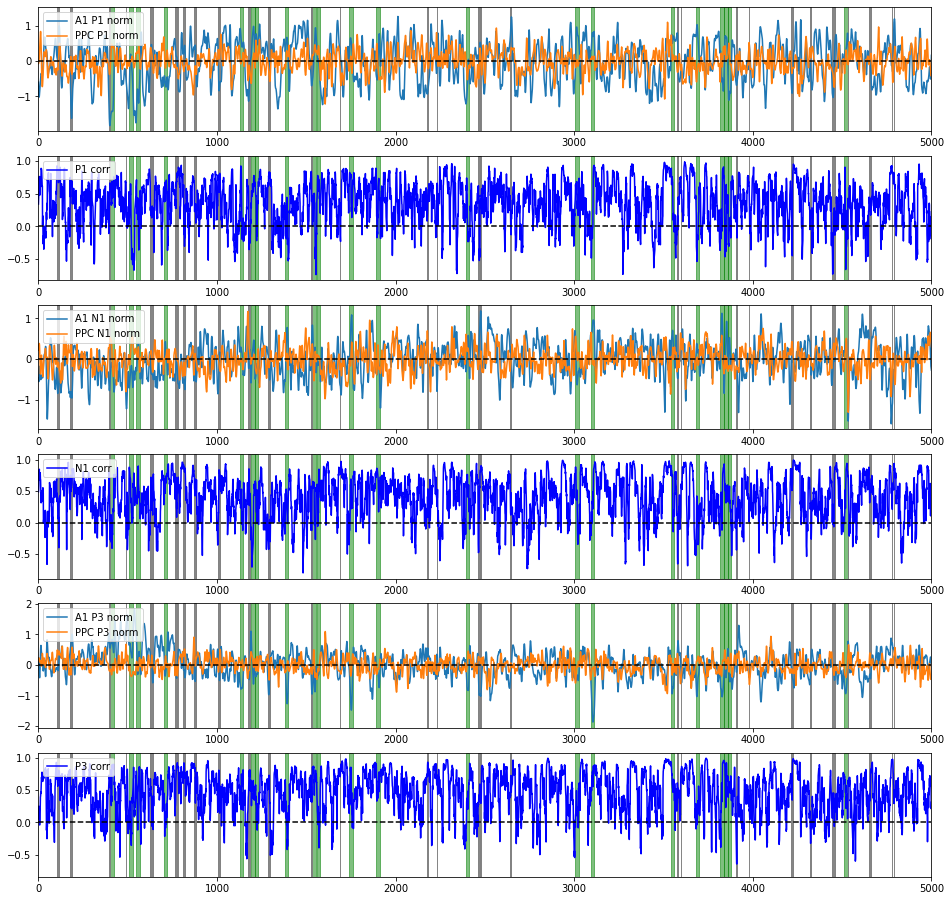

In [167]:
fig, axes = plt.subplots(6, 1, figsize=(16, 16))
axes[0].plot(AEP_metrics_norm_A1['P1'], color='tab:blue', label='A1 P1 norm')
axes[0].plot(AEP_metrics_norm_PPC['P1'], color='tab:orange', label='PPC P1 norm')
axes[1].plot(time_corrs_raw['P1'], color='blue', label='P1 corr')
axes[2].plot(AEP_metrics_norm_A1['N1'], color='tab:blue', label='A1 N1 norm')
axes[2].plot(AEP_metrics_norm_PPC['N1'], color='tab:orange', label='PPC N1 norm')
axes[3].plot(time_corrs_raw['N1'], color='blue', label='N1 corr')
axes[4].plot(AEP_metrics_norm_A1['P3'], color='tab:blue', label='A1 P3 norm')
axes[4].plot(AEP_metrics_norm_PPC['P3'], color='tab:orange', label='PPC P3 norm')
axes[5].plot(time_corrs_raw['P3'], color='blue', label='P3 corr')

for ax in axes:
    for succ_enters in tgt_matrix[tgt_matrix[:, 4] == 1]:
        ax.axvspan(succ_enters[2], succ_enters[3], alpha=0.5, color='green')
    for miss_enters in tgt_matrix[tgt_matrix[:, 4] == 0]:
        ax.axvspan(miss_enters[2], miss_enters[3], alpha=0.95, color='gray')
    ax.legend(loc='upper left')
    ax.axhline(0, color='black', ls='--')
    ax.set_xlim(0, 5000)

## Correlation distributions

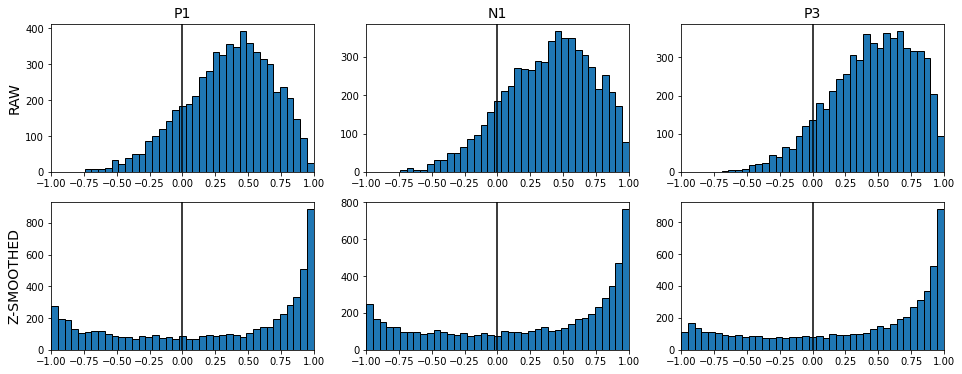

In [168]:
fig, axes = plt.subplots(2, 3, figsize=(16, 6))

titles = ['RAW', 'Z-SMOOTHED']
for j, time_corrs in enumerate([time_corrs_raw, time_corrs_norm]):
    for i, (name, data) in enumerate(time_corrs.items()):
        axes[j, i].hist(data, bins=np.linspace(-1, 1, 40), edgecolor='black')
        axes[j, i].axvline(0, color='black')
        axes[j, i].set_xlim(-1, 1)
        
        if i == 0:
            axes[j, i].set_ylabel(titles[j], fontsize=14)
        if j == 0:      
            axes[j, i].set_title(name, fontsize=14)

## Correlation between correlations

In [169]:
for m1, m2 in (['P1', 'N1'], ['P1', 'P3'], ['N1', 'P3']):
    print(stats.pearsonr(time_corrs_raw[m1], time_corrs_raw[m2]))
    print(stats.pearsonr(time_corrs_norm[m1], time_corrs_norm[m2]))

(0.16640193489137878, 2.6593423258365504e-38)
(-0.0013557425518432964, 0.9166174282394549)
(0.229268957958866, 5.295500980228525e-72)
(0.044850615695273474, 0.0005296910051576521)
(0.30011514664295763, 1.9916799547708185e-124)
(0.20334206857071224, 1.0406595612348744e-56)


## CCR of cross-area coherence with Target / Noize / Reward events

In [ ]:
# TDB